https://rob-p.github.io/CSE549F17/lectures/Lec08.pdf
https://academic.oup.com/bioinformatics/article/19/suppl_1/i54/227687

In [1]:
import pandas as pd
import numpy as np
def createScorMat(match = 1,mismatch = 0):
    """
    Create scoring matrix for nucleotides with a given match and mismatch values
    """
    nts = ['A','C','T','G']

    scoringMatrix = np.zeros((len(nts),len(nts)),)
    np.fill_diagonal(scoringMatrix,match)
    scoringMatrix
    scoringMatrix[scoringMatrix == 0] = mismatch
    scoringMatrix = pd.DataFrame(scoringMatrix,index=nts,columns=nts)
    return scoringMatrix

#### Dynamic programming implementation
def scoringMatrix_local(x,y,subMat,indel):
    m = len(x) + 1
    n = len(y) + 1
    globMax = (0,0)
    scoringMat=np.zeros((n,m))
    for i in range(1,m):
        #print(x[i-1])
        for j in range(1,n):
            if x[i-1] == y[j-1]:
                #scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
                scoringMat[j][i] = scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
            else:
                mismatch = scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
                left = scoringMat[j-1][i] + indel
                up = scoringMat[j][i-1] + indel
                scoringMat[j][i] = max(mismatch,left,up,0)
            if scoringMat[j][i] >= scoringMat[globMax[1]][globMax[0]]:
                globMax = (i,j)
    return scoringMat,globMax


def scoringMatrix_global(x,y,subMat,indel):
    m = len(x) + 1
    n = len(y) + 1
    scoringMat=np.zeros((n,m))
    scoringMat[:][0] = [0] + list(np.cumsum([indel for _ in x]))
    scoringMat[:,0] = [0] + list(np.cumsum([indel for _ in y]))
    for i in range(1,m):
        #print(x[i-1])
        for j in range(1,n):
            if x[i-1] == y[j-1]:
                #scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
                scoringMat[j][i] = scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
            else:
                mismatch = scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
                left = scoringMat[j-1][i] + indel
                up = scoringMat[j][i-1] + indel
                scoringMat[j][i] = max(mismatch,left,up)
    return scoringMat


def backtrack_local(x,y,sm,maxLocs):
    i = maxLocs[0]
    j = maxLocs[1]
    w=''
    z=''
    z,w
    while i*j > 0:
        if x[i-1] == y[j-1]:
            w += x[i-1]
            z += y[j-1]
            i -= 1
            j -= 1
        else:
            left = sm[j-1][i]
            up = sm[j][i-1]
            diag = sm[j-1][i-1]
            whichmax = np.argmax([left,up,diag])
            if whichmax == 0:
                w += '-'
                z += y[j-1]
                j -= 1
            elif whichmax == 1:
                z += '-'
                w += x[i-1]
                i -= 1
            else:
                w += x[i-1]
                z += y[j-1]
                i -= 1
                j -= 1
        if sm[j][i] == 0:
            break
    return w[::-1],z[::-1]

def backtrack_global(x,y,sm):
    i = len(x)
    j = len(y)
    w=''
    z=''
    z,w
    while i*j > 0:
        if x[i-1] == y[j-1]:
            w += x[i-1]
            z += y[j-1]
            i -= 1
            j -= 1
        else:
            left = sm[j-1][i] + indel
            up = sm[j][i-1] + indel
            diag = sm[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
            whichmax = np.argmax([left,up,diag])
            if whichmax == 0:
                w += '-'
                z += y[j-1]
                j -= 1
            elif whichmax == 1:
                z += '-'
                w += x[i-1]
                i -= 1
            else:
                w += x[i-1]
                z += y[j-1]
                i -= 1
                j -= 1
    if j==0 and i>0:
        w = x[:i]+w[::-1]
        z = '-' * i + z[::-1]
    elif i==0 and j>0:
        z = y[:i]+z[::-1]
        w = '-' * j + w[::-1]
    else:
        w = w[::-1]
        z = z[::-1]
    return w,z

def locAl(x,y,subMat,indel):
    '''
    A wrapper for DP implementation of Smith-Waterman
    '''
    sm, maxLocs = scoringMatrix_local(x,y,subMat,indel)
    z,w = backtrack_local(x,y,sm,maxLocs)
    return z,w,sm[maxLocs[1],maxLocs[0]]

def globAl(x,y,subMat,indel):
    '''
    A wrapper for DP implementation of Smith-Waterman
    '''
    sm = scoringMatrix_global(x,y,subMat,indel)
    z,w = backtrack_global(x,y,sm)
    return z,w,sm[len(y),len(x)]

def vizScoringMat(x,y,scoringMat):
    return pd.DataFrame(scoringMat,index=['']+[_ for _ in y],
             columns=['']+[_ for _ in x])

In [131]:
def kmerize(s,k):
    """
    Function to generate all kmers of size k
    """
    kmers = []
    for _ in range(0,len(s)-k+1):
        kmers.append(s[_:_+k])
    return kmers

def gloCal(x,y,subMat,indel):
    '''
    brute force
    '''
    
    ### Define target and query
    m = len(x)
    n = len(y)
    whichMax = np.argmax([m,n])
    
    if whichMax == 0: target,query = x,y
    else: target,query = y,x
    ### Get all possible kmers
    kmers = []
    for k in range(len(query),len(target)+1):
        kmers.append(kmerize(target,k))
    kmers = sum(kmers , []) #Unlist the list of lists
    res = {}
    for i,kmer in enumerate(kmers):
        res[i] = globAl(kmer,y,subMat,indel)
    
    return res[np.argmax([_[2] for _ in res.values()])]

http://rosalind.info/glossary/fitting-alignment/

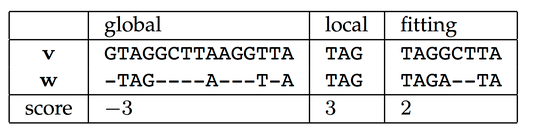

In [3]:
x='GTAGGCTTAAGGTTA'
y='TAGATA'
indel = -1
subMat = createScorMat(1,mismatch = -1)

In [4]:
globAl(x,y,subMat,indel)
# TAGGCTTA
# TAGA--TA

('GTAGGCTTAAGGTTA', '-TA-G----A---TA', -3.0)

In [5]:
locAl(x,y,subMat,indel)
# TAG
# TAG

('TAG', 'TAG', 3.0)

In [117]:
gloCal(x,y,subMat,indel)
#TAGGCTTA
#TAGA--TA

('TAGGCTTA', 'TAGA--TA', 2.0)

In [13]:
vizScoringMat(x,y,scoringMatrix_global(x,y,subMat,indel))

,,G,T,A,G,G,C,T,T,A,A,G,G,T,T,A
,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0,-11.0,-12.0,-13.0,-14.0,-15.0
T,-1.0,-1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0,-11.0,-12.0,-13.0
A,-2.0,-2.0,-1.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0,-11.0
G,-3.0,-1.0,-2.0,0.0,2.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0
A,-4.0,-2.0,-2.0,-1.0,1.0,1.0,0.0,-1.0,-2.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0
T,-5.0,-3.0,-1.0,-2.0,0.0,0.0,0.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-3.0,-4.0,-5.0
A,-6.0,-4.0,-2.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-3.0


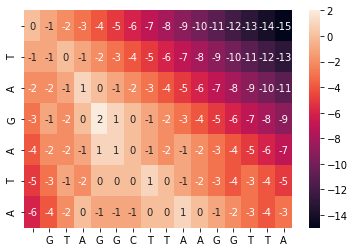

In [18]:
sns.heatmap(vizScoringMat(x,y,scoringMatrix_global(x,y,subMat,indel)),annot=vizScoringMat(x,y,scoringMatrix_global(x,y,subMat,indel)))

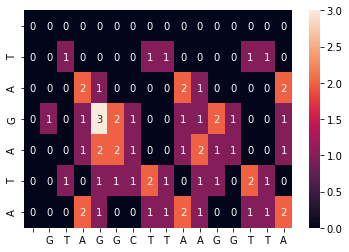

In [22]:
sns.heatmap(vizScoringMat(x,y,scoringMatrix_local(x,y,subMat,indel)[0]),
            annot=vizScoringMat(x,y,scoringMatrix_local(x,y,subMat,indel)[0]))


# TAGGCTTA
# TAGA--TA

In [135]:
def semiGlobal(x,y,subMat):
    """
    ##https://rob-p.github.io/CSE549F17/lectures/Lec08.pdf
    """
    m = len(x) + 1
    n = len(y) + 1
    scoringMat=np.zeros((n,m))
    scoringMat[:][0] = [0] + list(np.cumsum([0 for _ in x]))
    scoringMat[:,0] = [0] + list(np.cumsum([indel for _ in y]))
    for i in range(1,m):
        #print(x[i-1])
        for j in range(1,n):
            if x[i-1] == y[j-1]:
                #scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
                scoringMat[j][i] = scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
            else:
                mismatch = scoringMat[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
                left = scoringMat[j-1][i] + indel
                up = scoringMat[j][i-1] + indel
                scoringMat[j][i] = max(mismatch,left,up)

    lastRow = scoringMat[:][n-1]
    cutHere = np.where(lastRow == np.max(lastRow))[0][0]
    cutHere
    return scoringMat,cutHere

SyntaxError: invalid syntax (<ipython-input-135-f0f19571291a>, line 1)

In [132]:
m,n

(16, 7)

9

9

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,0.0
2,-2.0,-2.0,0.0,2.0,1.0,0.0,-1.0,0.0,0.0,2.0
3,-3.0,-1.0,-1.0,1.0,3.0,2.0,1.0,0.0,-1.0,1.0
4,-4.0,-2.0,-2.0,0.0,2.0,2.0,1.0,0.0,-1.0,0.0
5,-5.0,-3.0,-1.0,-1.0,1.0,1.0,1.0,2.0,1.0,0.0
6,-6.0,-4.0,-2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


('', '')

(15, 9)

In [130]:
sm = scoringMat[:,:cutHere+1]
i = cutHere
j = len(y)
w=''
z=''
z,w
while i*j > 0:
    print(w[::-1],z[::-1])
    if x[i-1] == y[j-1]:
        w += x[i-1]
        z += y[j-1]
        i -= 1
        j -= 1
    else:
        left = sm[j-1][i] + indel
        up = sm[j][i-1] + indel
        diag = sm[j-1][i-1] + subMat.loc[x[i-1]][y[j-1]]
        whichmax = np.argmax([left,up,diag])
        if whichmax == 0:
            w += '-'
            z += y[j-1]
            j -= 1
        elif whichmax == 1:
            z += '-'
            w += x[i-1]
            i -= 1
        else:
            w += x[i-1]
            z += y[j-1]
            i -= 1
            j -= 1
            
w[::-1],z[::-1]
# if j==0 and i>0:
#     w = x[:i]+w[::-1]
#     z = '-' * i + z[::-1]
# elif i==0 and j>0:
#     z = y[:i]+z[::-1]
#     w = '-' * j + w[::-1]
# else:
#     w = w[::-1]
#     z = z[::-1]
# return w,z


 
A A
TA TA
TTA -TA
CTTA --TA
GCTTA A--TA
GGCTTA GA--TA
AGGCTTA AGA--TA


('TAGGCTTA', 'TAGA--TA')

In [57]:
gloCal(x,y,subMat,indel)

('TAGGCTTA', 'TAGA--TA', 2.0)

#### Try this implementation later

https://academic.oup.com/bioinformatics/article/19/suppl_1/i54/227687

In [4]:
m = len(x)
n = len(y)
whichMax = np.argmax([m,n])
if whichMax == 0:
    target,query = x,y

else:
    target,query = y,x
target

'GTAGGCTTAAGGTTA'

In [143]:
def makeIndex(target,k=3):
    k = 3
    index = {}
    for _ in range(0,len(target)-2):
        kmer = target[_:_+k]
        if index.get(kmer) == None:
            index[kmer] = [_]
        else:
            index[kmer].append(_)
    return index
index = makeIndex(target,k=3)
index

{'GTA': [0],
 'TAG': [1],
 'AGG': [2, 9],
 'GGC': [3],
 'GCT': [4],
 'CTT': [5],
 'TTA': [6, 12],
 'TAA': [7],
 'AAG': [8],
 'GGT': [10],
 'GTT': [11]}

In [29]:
kmers = []
for _ in range(0,len(query)-2):
    kmers.append(query[_:_+k])
kmers

NameError: name 'k' is not defined

In [153]:
index.get(kmers[0])

[1]

In [162]:
globAl(target[1:],query,subMat,indel)

('TAGGCTTAAGGTTA', 'TA-G----A---TA', -2.0)